# Создание датафрейма, жёсткий парсинг без смс и регистрации
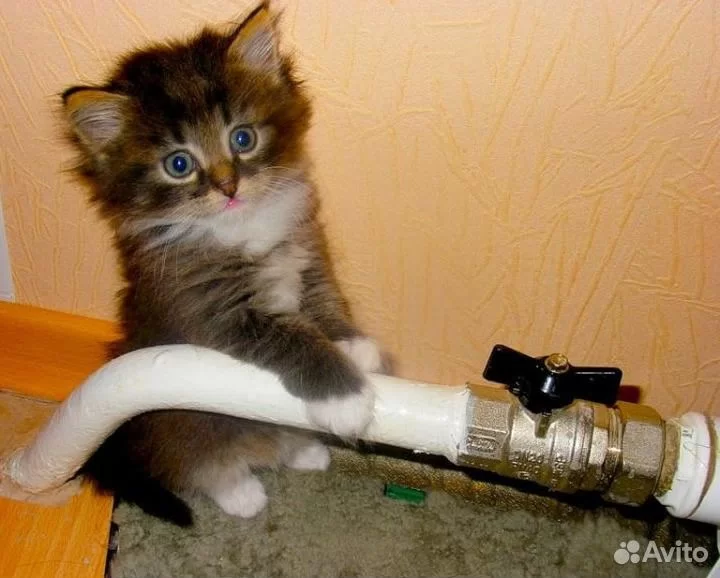


### Парсинг всех постов для анализа

In [19]:
import pandas as pd
import requests
import time
from tqdm import tqdm_notebook
from datetime import datetime
information_for_dataframe = {
    'id' : [],
    'text' : [], 
    'likes' : [],
    'comments' : [],
    'views' : [],
    'reposts':[], 
    'url' :[],
    'date' : [],
    'date_UNIX': []
}

#парсим данные со страницы
url_start = 'https://vk.com/dimdimychmusic'
url=url_start.split('/')
access_token="vk1.a.zPEtzBOVfFVEnCAaT2cMvW6CYvsFyOFiB8NFFU9GEz-sWujzUYZuA00WoHRpykSBtNni2EkFM4s4xLB_4_CcWk5SjN-pyh0xoe-pH4OO0CxWWzY1fXxsAzYq0dCXwHimF3p_is6GIyH_wvL0yCGd3SFKeBncr_NOpuodwPr7Hr6Zi9YrG8AQqVtp3Jo-jzA_cFS-1WKcAYnA06vt18QxZg"
version = 5.199
domain = url[-1]
count = 100
offset = 0

response = requests.get('https://api.vk.com/method/wall.get',
            params={'access_token': access_token,
                    'v': version,
                    'domain': domain,
                    'count': count,
                    'offset': offset
                    })

data_start = response.json()
response = requests.get('https://api.vk.com/method/utils.resolveScreenName',
            params={'access_token': access_token,
                    'screen_name': domain,
                    'v' : version
                    })
id_group=response.json()['response']['object_id']
print(id_group)
count_posts = data_start['response']['count']
for i in tqdm_notebook(range(0, count_posts, 100)):
    response = requests.get('https://api.vk.com/method/wall.get',
            params = {'access_token': access_token,
                    'v': version,
                    'domain': domain,
                    'count': count,
                    'offset': offset
                    })
    data = response.json()['response']['items']
    offset += 100
    information_for_dataframe['id'].extend([item['id'] for item in data])
    information_for_dataframe['likes'].extend([item['likes']['count'] for item in data])
    information_for_dataframe['text'].extend([item['text'] for item in data])
    information_for_dataframe['comments'].extend([item['comments']['count'] for item in data])
    #c 2017 и позже не отображаются просмотры, т.к.не было такой функции для публичного доступа.
    for item in data:
        if 'views' in item:
                information_for_dataframe['views'].append(item['views']['count'])
        else:
            information_for_dataframe['views'].append(None)
    information_for_dataframe['reposts'].extend([item['reposts']['count'] for item in data])
    information_for_dataframe['url'].extend([url_start + "?w=wall-" + str(id_group) +"_"+ str(item['id']) for item in data])
    information_for_dataframe['date'].extend([datetime.utcfromtimestamp(item['date']).strftime('%Y-%m-%d') for item in data])
    information_for_dataframe['date_UNIX'].extend([item['date'] for item in data])
    time.sleep(0.00001)
df_posts = pd.DataFrame(information_for_dataframe)
df_posts.head()

13537150


C:\Users\Настя\AppData\Local\Temp\ipykernel_4132\4252848909.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(0, count_posts, 100)):


  0%|          | 0/7 [00:00<?, ?it/s]

,id,text,likes,comments,views,reposts,url,date,date_UNIX
0,1382,"ПРЕМЬЕРА ПЕСНИ\nДрузья, к празднованию 650-лет...",104,11,3512.0,32,https://vk.com/dimdimychmusic?w=wall-13537150_...,2024-03-13,1710358580
1,1438,,34,0,236.0,0,https://vk.com/dimdimychmusic?w=wall-13537150_...,2024-04-14,1713106699
2,1434,"Мы не пропали - мы работаем, получится что-то ...",60,3,865.0,0,https://vk.com/dimdimychmusic?w=wall-13537150_...,2024-04-09,1712662742
3,1425,"29го марта на нашем концерте в Книжном Клубе ""...",40,8,923.0,3,https://vk.com/dimdimychmusic?w=wall-13537150_...,2024-03-31,1711886438
4,1424,"Завтра, в пятницу 29 марта с 19.00 в Книжном К...",52,0,805.0,1,https://vk.com/dimdimychmusic?w=wall-13537150_...,2024-03-28,1711633154


### Парсинг всех метрик по периодам



In [73]:
import pandas as pd
import requests

def fetch_vk_stats(start_time, end_time, access_token, id_group):
    # Загрузка всех параметров
    params = {
        'access_token': access_token,
        'group_id': id_group,
        'timestamp_from': start_time,
        'timestamp_to': end_time,
        'v': version
    }

    # Запрос к апи
    response = requests.get('https://api.vk.com/method/stats.get', params=params)
    
    response_data = response.json()['response']
    

    # Инициализация заготовок
    # Initialize empty lists to store the extracted data
    likes, copies, hidden, comment, subscribed, unsubscribed, visitors = [], [], [], [], [], [], []
    sex_f, sex_m = [], []
    age_data = {}
    age_sex_data = {}

    for item in response_data:
        activity = item.get("activity", {})  # Handle empty "activity" case
        reach = item.get("reach", {})

        # Extracting activity data
        likes.append(activity.get("likes", 0))
        copies.append(activity.get("copies", 0))
        hidden.append(activity.get("hidden", 0))
        comment.append(activity.get("comment", 0))
        subscribed.append(activity.get("subscribed", 0))
        unsubscribed.append(activity.get("unsubscribed", 0))
        visitors.append(reach.get("reach", 0))

        # Extracting sex data
        for sex in reach.get("sex", []):
            if sex["value"] == "f":
                sex_f.append(sex["count"])
            elif sex["value"] == "m":
                sex_m.append(sex["count"])

        # Extracting age data
        for age_group in reach.get("age", []):
            age_data[age_group["value"]] = age_group["count"]

        # Extracting sex-age data
        for sex_age in reach.get("sex_age", []):
            age_sex_data[sex_age["value"]] = sex_age["count"]

    # Creating the dataframes
    activity_df = pd.DataFrame({"likes": likes, "copies": copies, "hidden": hidden, "comment": comment,
                                 "subscribed": subscribed, "unsubscribed": unsubscribed, "visitors": visitors})
    
    sex_df = pd.DataFrame({"f": sex_f, "m": sex_m})
    age_df = pd.DataFrame(list(age_data.items()), columns=["age_group", "count"])
    age_sex_df = pd.DataFrame(list(age_sex_data.items()), columns=["sex_age", "count"])

    return activity_df, sex_df, age_df, age_sex_df
start_time = '1709286555'
end_time = '1713174555'



# Вызов функции
activity_df, sex_df, age_df, age_sex_df = fetch_vk_stats(start_time, end_time, access_token, id_group)


print("Activity DataFrame:")
print(activity_df)
print("\nSex DataFrame:")
print(sex_df)
print("\nAge DataFrame:")
print(age_df)
print("\nSex-Age DataFrame:")
print(age_sex_df)

Activity DataFrame:
    likes  copies  hidden  comment  subscribed  unsubscribed  visitors
0      12       0       0        0           0             0        75
1      24       0       0        0           1             0       204
2       0       0       0        0           1             0        44
3       1       0       0        0           1             0        67
4       1       0       0        0           0             0       111
5       8       0       0        0           0             0       218
6      52       0       1        0           0             0       558
7       1       1       0        0           0             0        14
8       0       0       0        0           0             0        23
9       0       0       0        0           0             0        16
10      0       0       0        0           1             0        23
11      0       0       1        0           0             0        34
12      1       0       0        0           0           